In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [6]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [7]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

In [8]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag", "tracer01Diag", "tracer02Diag"], delta_t=60.)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [9]:
extend_multiples = [-6, 1]
xslice = [-1e6,1.5e6]
xslice = [-np.inf,np.inf]

Lx = ds['XC'].size*dx
ds = periodic_extend(ds, ['XC', 'XG'], Lx, extend_multiples)
ds = ds.sel(XC=slice(*xslice), XG=slice(*xslice))
H = ds['Depth'].max().values.copy().astype('>f8')
ds, grid = preprocess(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

In [10]:
ds = ds.chunk({'XC': 400, 'XG': 400})

In [11]:
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']
ds['θ'] = ds['θ'].where(ds['hFacC'] != 0)

In [12]:
dθ = 0.1
θlevs = np.arange(0.-1*dθ, 1.+2*dθ, dθ)

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xarray/plot/plot.py:906: UserWarning: The following kwargs were not used by contour: 'lw'
  primitive = ax.contour(x, y, z, **kwargs)


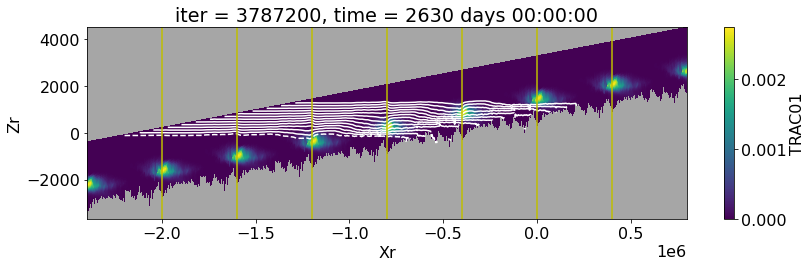

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1, facecolor=nancol)
ds['TRAC01'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot(x='Xr', y='Zr')
ds['θ'].where(ds['hFacC'] != 0.).isel(time=-1).mean(dim='YC').plot.contour(x='Xr', y='Zr', levels=θlevs, colors='w', lw=0.75)
plt.tight_layout()
#plt.ylim([-500, 1500])

for i in range(*extend_multiples):
    plt.axvline(x=(i+1)*(800*500), alpha=1, linestyle="-", color="y")

## Temperature budget

In [49]:
day2seconds = 1./(86400.)
tmp = tracer_flux_budget(ds, grid, '_TH', Γ = Γ, θ = θ).chunk({'Z': -1, 'YC': -1, 'XC': 400})
tmp['total_tendency_TH'] = tmp['conv_total_flux_TH'].fillna(0.)
tmp['total_tendency_TH_truth'] = ds.TOTTTEND * ds['dV'] * day2seconds
tmp['diff_tendency_TH'] = tmp['conv_horiz_diff_flux_TH'] + tmp['conv_vert_diff_flux_TH'] + tmp['conv_vert_diff_flux_anom_TH']
tmp['adv_tendency_TH'] = tmp['conv_horiz_adv_flux_TH'] + tmp['conv_vert_adv_flux_TH'] + tmp['conv_adv_flux_anom_TH']

ds = xr.merge([ds, tmp])

In [55]:
h = histogram(ds['θ'], bins=[θlevs], weights=ds['diff_tendency_TH']).compute()

In [ ]:
dθ = 0.05
θlevs = np.arange(0.-dθ, 1.+dθ, dθ)

T = histogram(
    ds['θ'],
    bins=[θlevs],
    weights=-ds['diff_tendency_TH'].where(~np.isnan(ds['diff_tendency_TH']), 0.),
    dim=('XC', 'YC', 'Z',)
).compute()/dθ

In [109]:
transformation = h/dθ

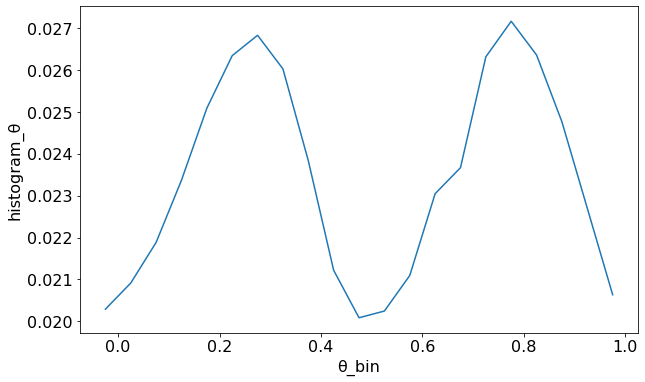

In [114]:
(-transformation*1e-6).mean(dim='time').plot()

In [131]:
inty = ds['diff_tendency_TH'].sel(XC=slice(-5e5, 2.5e5)).sum(dim='YC').isel(time=-1).compute()


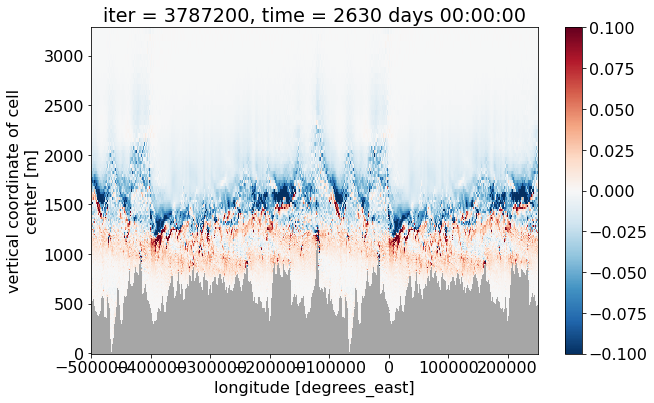

In [135]:
inty = inty.where(inty!=0, np.nan)
q = (inty/ds['drF']).plot()
q.set_clim([-0.1, 0.1])

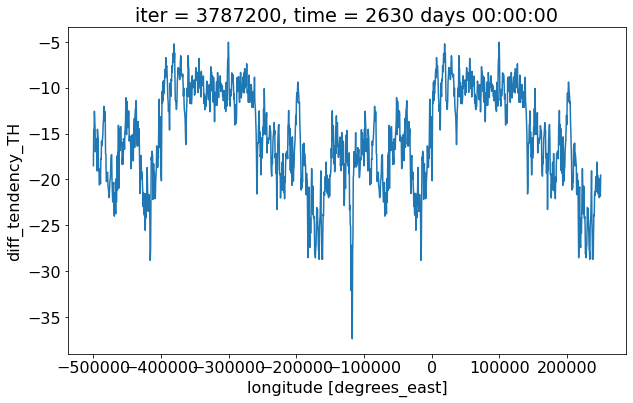

In [137]:
q = inty.sum(dim='Z', skipna=True).plot()

TypeError: Cannot cast scalar from dtype('float64') to dtype('<m8[ns]') according to the rule 'same_kind'

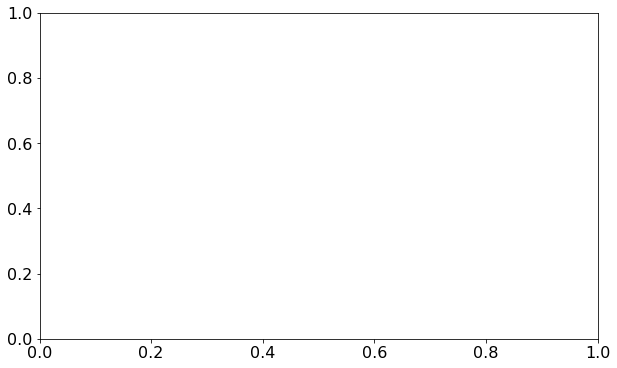

In [139]:
h.plot(y = "θ_bin", color="C0", linestyle="-")

## Watermass Transformation

In [ ]:
formation = np.zeros((θlevs.size, 3))
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation[k, 0] = TH['diff_tendency_TH'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    formation[k, 1] = TH['diff_tendency_TH'].where((ds['θ'] < θlev) | (TH['diff_tendency_TH'] >= 0.)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    formation[k, 2] = TH['diff_tendency_TH'].where((ds['θ'] < θlev) | (TH['diff_tendency_TH'] <= 0.)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values

transformation = -np.diff(formation, axis=0)/dθ

0, 

In [ ]:
formation_adv = np.zeros(θlevs.size)
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation_adv[k] = TH['adv_tendency_TH'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values
    
transformation_adv = -np.diff(formation_adv)/dθ

formation_dbdt = np.zeros(θlevs.size)
for k, θlev in enumerate(θlevs):
    print(k, end=", ")
    formation_dbdt[k] = TH['total_tendency_TH_truth'].where((ds['θ'] < θlev)).sum(dim=['XC', 'YC', 'Z']).mean(dim='time').compute().values

transformation_dbdt = -np.diff(formation_dbdt)/dθ

In [ ]:
θlevs_f = 0.5*(θlevs[1:] + θlevs[0:-1])
labels = ['Net', 'BBL', 'SML']
colors = ['k', 'C3', 'C0']

plt.figure(figsize=(6,8))
for i in range(3):
    plt.plot(transformation[:,i]*1.e-3, θlevs_f, label=labels[i], color=colors[i], lw=2.)

plt.plot(transformation_dbdt[:]*1.e-3, θlevs_f, color="C1", lw=1., label="Tendency")
plt.plot(transformation_adv[:]*1.e-3, θlevs_f, color="C2", lw=1., label="Advection")
    
Tinf = 5.2e-5 * np.tan(θ)**(-1) * 120 * 500
plt.axvline(x=Tinf*1.e-3, alpha=0.8, linestyle=":", color="k")
plt.grid(True)
plt.legend()
plt.xlabel("watermass transformation (mSv)")
plt.ylabel(r"$\Theta$ [$\degree$C]")
plt.xlim([-100, 100])
plt.ylim([0., 1.])